In [ ]:
# Import libraries
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt

import datetime
from tqdm import tqdm

import cv2
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading in data


In [ ]:
# mean's and sd's
train_mean, train_sd = [0.49139968, 0.48215827, 0.44653124], [ 0.24703233, 0.24348505, 0.26158768]

# set up training and validation sets
cifar_data = datasets.CIFAR10('data', train=True, download = True, 
                            transform=transforms.Compose([
                               transforms.ToTensor(), # scale to values between 0 & 1 first.
                               transforms.Normalize( # then, normalize the data so that 
                                 train_mean, train_sd) # we have mean 0 and sd 1
                             ]))

Files already downloaded and verified


# Preprocess the data

In [ ]:
from google.colab.patches import cv2_imshow
full_dataset = []
images_input = []
images_output = []
for i in range(len(cifar_data.data)):
  img = cifar_data.data[i]
  scaled = img.astype("float32") / 255.0
  lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

  l, a, b = cv2.split(lab)
  a_b = cv2.merge([a, b])

  inp = torch.Tensor(l.reshape(1,32,32))
  out = torch.Tensor(a_b)

  full_dataset.append([inp, torch.permute(out, (2, 0, 1))])


In [ ]:
print(full_dataset[0][0].shape)
print(full_dataset[0][1].shape)

torch.Size([1, 32, 32])
torch.Size([2, 32, 32])


In [ ]:
# split into batches
bch_size = 32 # batch size for training
val_bch_size = 10 # validation set batch size

# number of pictures in the training and validation sets
train_size = 45000
val_size = 5000

In [ ]:
# dataset_images = list(cifar_data)

train_data = full_dataset[:train_size] 

val_data = full_dataset[train_size:(train_size + val_size + 1)] 

In [ ]:
train_loader = torch.utils.data.DataLoader(full_dataset, 
                                           batch_size=bch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=val_bch_size, 
                                         shuffle=True)

# The Model

In [ ]:
class Color(nn.Module):
    def __init__(self):
        super(Color, self).__init__()
        self.network = nn.Sequential(
          nn.Conv2d(1, 64, 3),
          nn.MaxPool2d(2, 2),
          # nn.BatchNorm2d(64),
          
          nn.Conv2d(64, 128, 3),
          nn.MaxPool2d(2, 2),
          # nn.BatchNorm2d(128),
          
          nn.Conv2d(128, 256, 3),
          nn.MaxPool2d(2, 2),
          nn.Upsample(scale_factor=2),
          # nn.BatchNorm2d(256),

          nn.Conv2d(256, 512, 1),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(512),

          nn.Conv2d(512, 256, 3),
          nn.MaxPool2d(2, 2),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(256),

          nn.Conv2d(256, 128, 3),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(128),

          nn.Conv2d(128, 64, 3),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(64),

          nn.Conv2d(64, 2, 3)
          # nn.Upsample(scale_factor=2)
        )
        
    def forward(self, x):
        x = self.network(x)
        x = F.interpolate(x, (32,32))
        # print("shape x:", x.shape)
        
        # flattened = x.view(-1, 256*27*27) 
        # x = F.relu(self.fc1(flattened))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x) #cross entropy loss?
        return x

In [ ]:
torch.manual_seed(2023)

model = Color()

print(model)

Ex1Net(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Upsample(scale_factor=2.0, mode='nearest')
    (7): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Upsample(scale_factor=2.0, mode='nearest')
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

print(get_output_shape(model, (0,1,32,32))) # sanity check from https://stackoverflow.com/a/62197038

torch.Size([0, 2, 32, 32])


In [ ]:
def train(model, criterion, train_loader, val_loader, avg_val_loss, avg_val_acc, train_losses, num_epoch, 
          lr, bsize, start_epoch = 0):

    optimizer = optim.Adam(model.parameters(), lr=lr, momentum=0.9)
    
    for epoch in range(start_epoch, start_epoch + num_epoch):
        model = model.to(device) 
        model.train() 

        with tqdm(train_loader, desc=f"Training Epoch {epoch}") as t:
            trainLoss = []   
            for batch_idx, (inputs, labels) in enumerate(t):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad() # a clean up step for PyTorch
                loss.backward() # compute updates for each parameter
                optimizer.step() # make the updates for each parameter
                
                t.set_postfix({'training_loss': loss.item()})
                trainLoss.append(loss.item())                         
            train_losses.append(np.mean(trainLoss))

        val_loss, correct = 0.0, 0
        model.eval() # sets the mode for validation
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() 
        avg_val_loss.append(val_loss / len(val_loader))
    return avg_val_loss, avg_val_acc, train_losses

In [ ]:
random_seed = 2023
torch.manual_seed(random_seed)

lr = 0.0001
criterion = nn.MSE()

In [ ]:
num_epoch = 100
avg_val_loss, avg_val_acc, train_losses = train(model, criterion, train_loader, val_loader, [], [], [], num_epoch, lr = lr, bsize = bch_size, start_epoch = 0)

Validating: 100%|██████████| 500/500 [00:00<00:00, 710.28it/s]


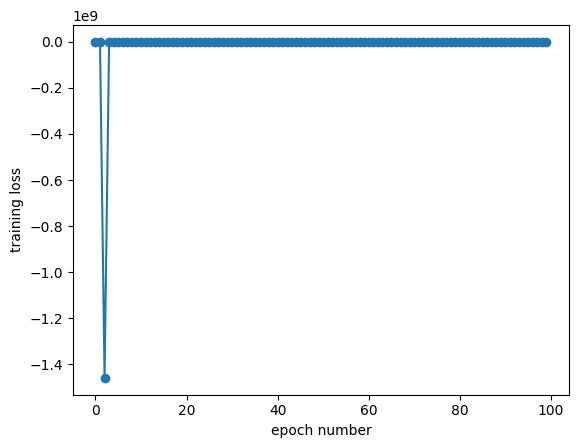

In [ ]:
plt.ylabel('training loss')
plt.xlabel('epoch number')
plt.plot(train_losses, linestyle='-', marker='o')

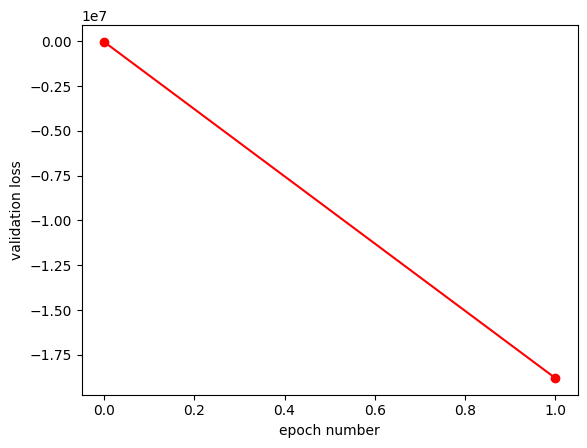

In [ ]:
plt.ylabel('validation loss')
plt.xlabel('epoch number')
plt.plot(avg_val_loss, linestyle='-', marker='o', color='red')

In [ ]:
PATH = "CIFAR100epoch_512Features.pth"
torch.save(model.state_dict(), PATH)

(32, 32, 2)
(32, 32)
(32, 32, 3)


((-0.5, 31.5, 31.5, -0.5), (-0.5, 31.5, 31.5, -0.5))

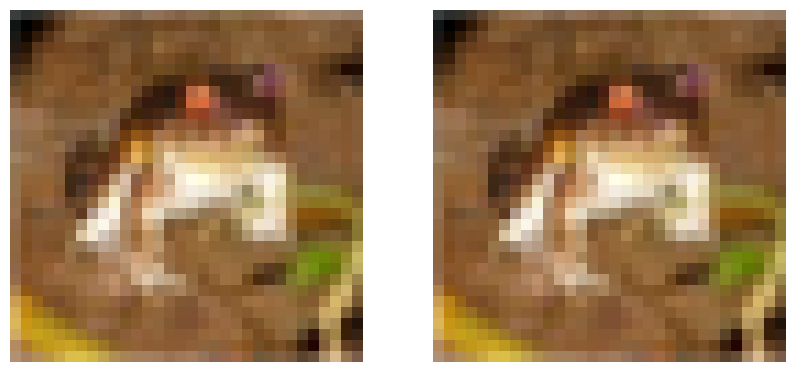

In [ ]:
from google.colab.patches import cv2_imshow
from skimage.color import lab2rgb, rgb2lab, rgb2gray
img = cifar_data.data[0]
scaled = img.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

l, a, b = cv2.split(lab)
a_b = cv2.merge([a, b])
print(a_b.shape)
print(l.shape)
l = np.reshape(l,(32,32,1))
# imgab = np.concatenate((l, a_b), axis=2)
imgab = cv2.merge([l, a_b])
print(imgab.shape)

f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 10)

axarr[0].imshow(img)
axarr[1].imshow(lab2rgb(imgab))
axarr[0].axis('off'), axarr[1].axis('off')

# cv2_imshow(img)
# cv2_imshow(lab2rgb(imgab))

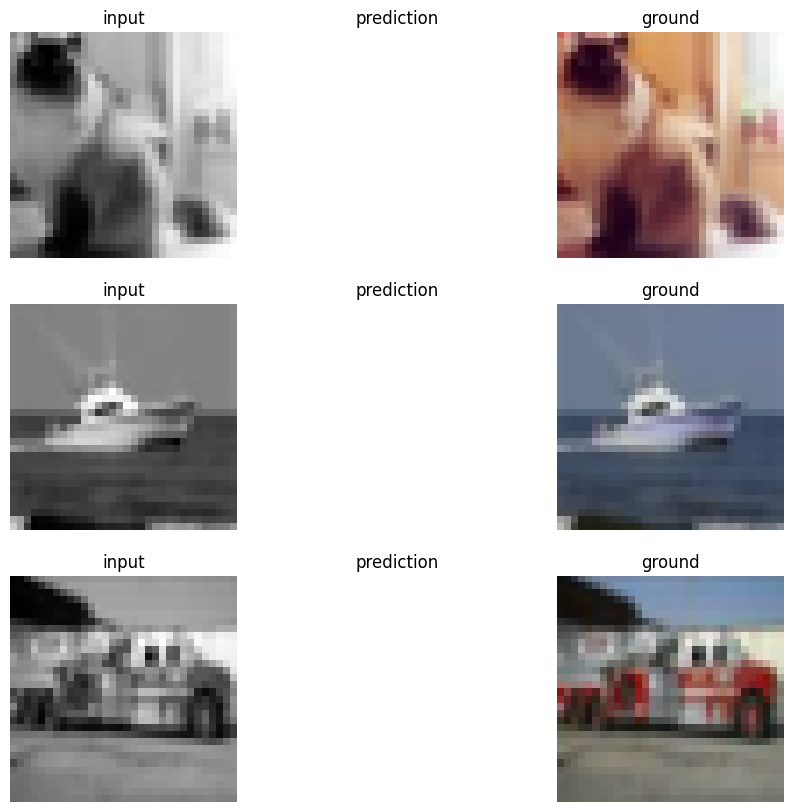

In [ ]:
model = model.to(torch.device('cpu'))
predicts = []
for i in range(5):
  x = full_dataset[i][0][None]
  prediction = model(x).squeeze(0)
  predicts.append(prediction)

f, axarr = plt.subplots(3, 3)
f.set_size_inches(10, 10)
j = 0

for i in range(49500, 49503):
  color_image = torch.cat((full_dataset[i][0], predicts[j]), 0).detach().numpy()
  color_image = color_image.transpose((1, 2, 0))
  color_image = cv2.cvtColor(color_image, cv2.COLOR_LAB2RGB)

  ground = torch.cat((full_dataset[i][0], full_dataset[i][1]), 0).numpy()
  ground = ground.transpose((1, 2, 0))
  ground = cv2.cvtColor(ground, cv2.COLOR_LAB2RGB)

  axarr[j][0].imshow(full_dataset[i][0].squeeze().numpy(), cmap='gray')
  axarr[j][1].imshow(color_image)
  axarr[j][2].imshow(ground)
  # axarr[j][3].imshow(cifar_data.data[i])
  axarr[j][0].axis('off'), axarr[j][1].axis('off'), axarr[j][2].axis('off')#, axarr[j][3].axis('off')
  axarr[j][0].set_title('input'), axarr[j][1].set_title('prediction'), axarr[j][2].set_title('ground')#, axarr[j][3].set_title('ground')
  j += 1
plt.show()